In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Collect the names of tables within the database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# the column names within the 'station' table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
engine.execute("SELECT * FROM Measurement LIMIT 10").fetchall()
session.query(func.count(Measurement.date)).all()

# Calculate the date 1 year ago from the last data point in the database
# the lastest date points
last_data = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).all()
last_data

[('2017-08-23')]

In [14]:
# the lastest date point
last_date = last_data[0][0]
last_date

'2017-08-23'

In [15]:
# the last 12 months of precipitation data: from 2016-08-23 to 2017-08-23
# Perform a query to retrieve the data and precipitation scores
precipitation_last_yr = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation_last_yr, columns=['date', 'prcp']).set_index('date')
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [16]:
# Sort the dataframe by date
precipitation_df = df.sort_values(by='date', ascending=True)
precipitation_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


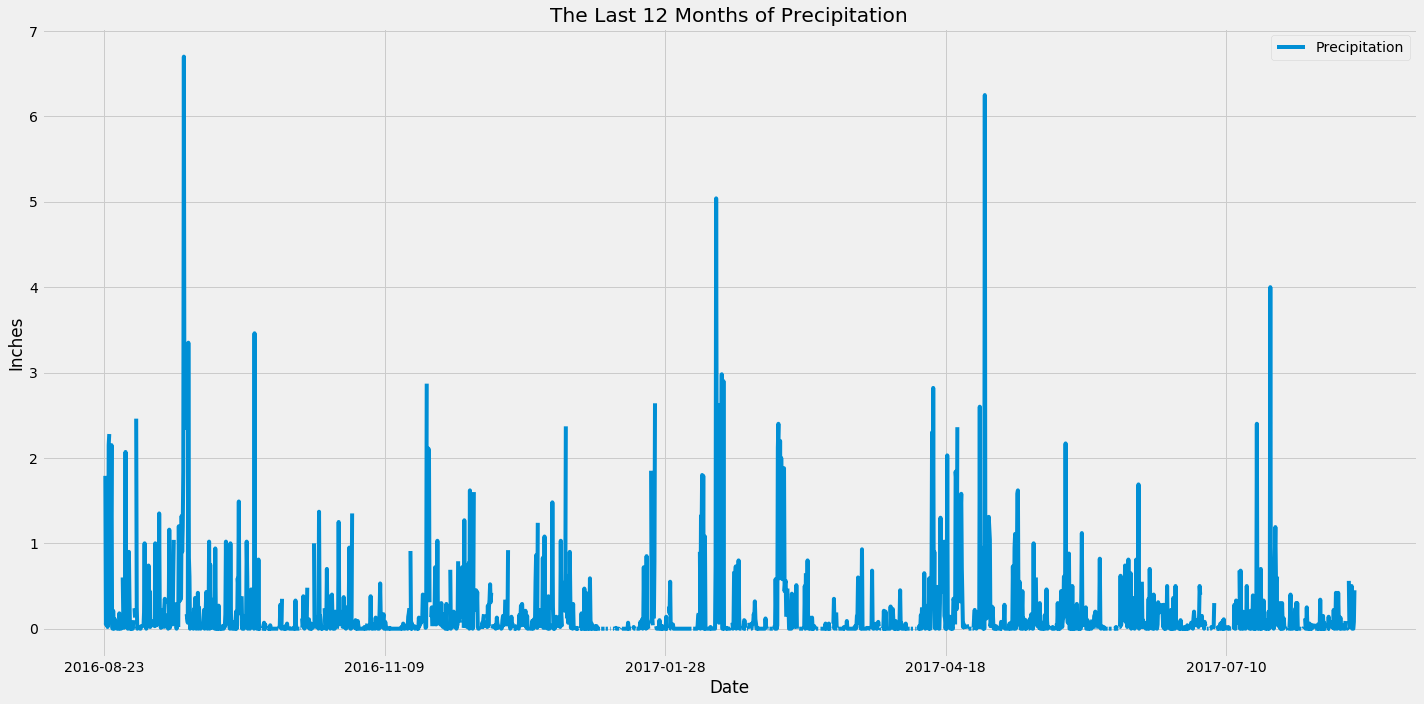

In [27]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (20, 10))
precipitation_df.plot(ax = ax)

ax.set_xlabel('Date')
ax.set_ylabel('Inches')
ax.set_title("The Last 12 Months of Precipitation")
ax.legend(['Precipitation'])

plt.tight_layout()

plt.savefig("Images/01precipitation.png")

plt.show()

In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [29]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).distinct().count()
print(f"Station Count: {station_count}")

Station Count: 9


In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# The station with the highest count of observations:
print(f'The most active station is {most_active_stations[0][0]} with the observation count of {most_active_stations[0][1]}.')

The most active station is USC00519281 with the observation count of 2772.


In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest_temp = session.query(func.max(Measurement.tobs))\
                      .filter(Measurement.station == 'USC00519281')\
                      .first()

lowest_temp = session.query(func.min(Measurement.tobs))\
                      .filter(Measurement.station == 'USC00519281')\
                      .first()

average_temp = session.query(func.avg(Measurement.tobs))\
                      .filter(Measurement.station == 'USC00519281')\
                      .first()

print (f'Highest Temperature: {highest_temp} Lowest Temperature: {lowest_temp} Average Temperature: {average_temp}')

Highest Temperature: (85.0,) Lowest Temperature: (54.0,) Average Temperature: (71.66378066378067,)


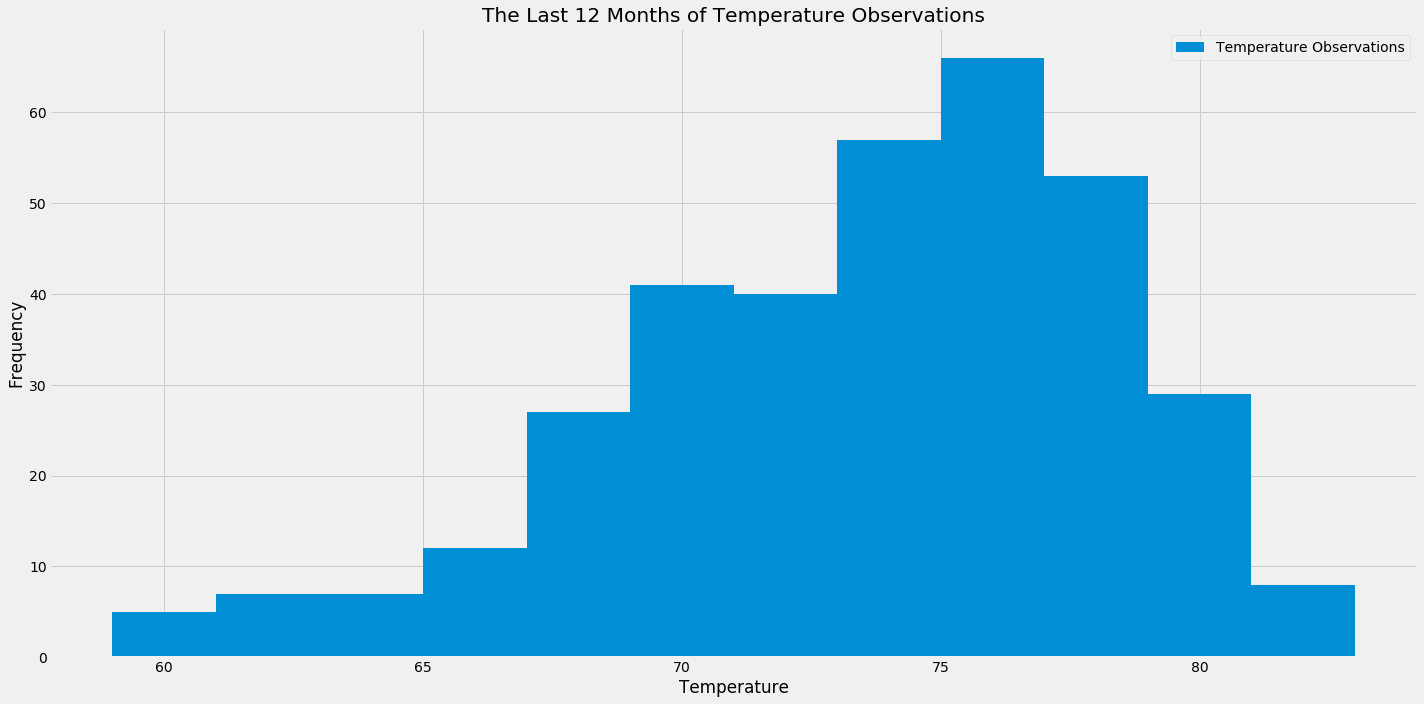

In [33]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_last_yr = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.station == "USC00519281").\
                        filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
temperature_df = pd.DataFrame(temperature_last_yr, columns=['date', 'temperature']).set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (20, 10))
temperature_df.plot.hist(bins = 12, ax = ax)

ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
ax.set_title("The Last 12 Months of Temperature Observations")
ax.legend(['Temperature Observations'])

plt.tight_layout()
plt.savefig("Images/02tobs.png")
plt.show()

## Bonus Challenge Assignment

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
